In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import minimize_scalar

np.random.seed(0)

## Generate data, Estimators

In [3]:
# params
p = 200
c1 = 90
c2 = 400
n1 = c1 * p
n2 = c2 * p
sigma = 4

# covariates
X2 = np.random.randn(n2, p)

# models
beta_t = np.random.randn(p, 1)

# labels
Y2 = X2 @ beta_t + sigma * np.random.randn(n2, 1)
hat_beta_t = np.linalg.inv(X2.T @ X2) @ X2.T @ Y2

def te_target(X1, X2, beta_s, beta_t, w, sigma_2 = sigma, Sigma2_sqrt = np.eye(p)):
    K = np.linalg.inv(w**2 * X1.T @ X1 + X2.T @ X2)
    beta_diff = beta_s - w * beta_t
    
    var = sigma_2**2 * np.trace(K @ Sigma2_sqrt @ Sigma2_sqrt)
    model_shift_bias = w**2 * np.linalg.norm(Sigma2_sqrt @ K @ X1.T @ X1 @ beta_diff) **2
    return model_shift_bias + var

def mtl_target(X1, X2, beta_s, beta_t, w, n1, n2, Sigma_1_sqrt = np.eye(p), Sigma_2_sqrt = np.eye(p)):
    K = np.linalg.inv(w**2 * X1.T @ X1 + X2.T @ X2)
    beta_diff = beta_s - w * beta_t
    
    var = sigma**2 * (n1 + n2) * np.trace(K)
    model_shift_bias = n1 * (np.linalg.norm(K @ X2.T @ X2 @ beta_diff) ** 2)
    model_shift_bias += n2 * w**2 * (np.linalg.norm(K @ X1.T @ X1 @ beta_diff) ** 2)
    return (model_shift_bias + var) / (n1 + n2)

## Find optimal w

In [4]:
def opt_w_val(X1, X2, beta_s, beta_t, n1, n2, c = 1, lb = 0.0, ub = 5.0, num = 10):
    def f_val(w):
        return mtl_target(X1, X2, beta_s, beta_t, w, n1, n2)
    
    gap = ub / num
    x_list = []
    fun_list = []
    for u in range(0, num):
        res = minimize_scalar(f_val, bounds=(gap* u, gap* (u+1)), method='bounded')
        x_list.append(res.x)
        fun_list.append(res.fun)
    
    plt.figure(c)
    plt.plot(x_list, fun_list)
    
    return x_list[np.argmin(fun_list)]

def opt_w(X1, X2, beta_s, beta_t, c = 1, lb = 0.0, ub = 5.0, num = 10):
    def f(w):
        return te_target(X1, X2, beta_s, beta_t, w)

    gap = ub / num
    x_list = []
    fun_list = []
    for u in range(0, num):
        res = minimize_scalar(f, bounds=(gap* u, gap* (u+1)), method='bounded')
        x_list.append(res.x)
        fun_list.append(res.fun)
        
    plt.figure(c)
    plt.plot(x_list, fun_list)
        
    return x_list[np.argmin(fun_list)]

In [5]:
#sigma = 4
#c2 = 500
#print(sigma, c2)

#d = 0.02
#threshold_ex = sigma**2 / (p * d**2 - sigma**2 / c2)

#print('is negative when c1 is large', c2 > threshold_ex)

#print(threshold_ex)
#c1 = 200
#lb = sigma**2 / (p * d**2 * (1 + 1.0 / math.sqrt(c1))**4 - sigma**2 / c2)
#print(lb)

#c1 = 500
#ub = sigma**2 / (p * d**2 * (1 - 1.0 / math.sqrt(c1))**4 - sigma**2 / c2)
#print(ub)

## Test errors and transfer

In [6]:
def test_errors_and_transfer(c1, d):
    beta_s = beta_t + d * np.random.randn(p, 1)
    n1 = c1 * p
    X1 = np.random.randn(n1, p)
    Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

    te_beta_t = te_target(X1, X2, beta_t, beta_t, 0)

    w_hat = opt_w_val(X1, X2, beta_s, beta_t, n1, n2)
    te_beta_st = te_target(X1, X2, beta_s, beta_t, w_hat)
    print('Test error:', 'STL', te_beta_t, 'MTL', te_beta_st, 'OPT_W', w_hat)

    if te_beta_st < te_beta_t:
        print('Positive transfer')
    else:
        print('Negative transfer')
        
    delta_beta = p * ((1 - w_hat)**2 + d**2) * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3
    delta_var = sigma**2 * c1 / ((c2 - 1) * (c1 + c2 - 1))
    deviation_ub = (1 + math.sqrt(1/c1))**4
    deviation_lb = (1 - math.sqrt(1/c1))**4

    print(delta_var, delta_beta, delta_var / delta_beta)

    if delta_var / delta_beta >= deviation_ub:
        print('Provably positive')
    elif delta_var / delta_beta <= deviation_lb:
        print('Provably negative')

    print(deviation_lb, deviation_ub)

#d = 0.02
#c1 = 50
#test_errors_and_transfer(c1, d)

#c1 = 500
#test_errors_and_transfer(c1, d)

## Plot the effect of task distance

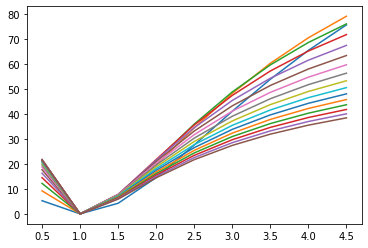

In [63]:
d = 0.015
c1_list = [50 * i for i in range(1, 17)]
te_mtl_list = []

provable_pos = [[], []]
provable_neg = [[], []]
unknown = [[], []]

beta_s = beta_t + d * np.random.randn(p, 1)

for c1 in c1_list:
    n1 = c1 * p
    X1 = np.random.randn(n1, p)
    Y1 = X1 @ beta_s + sigma * np.random.randn(n1, 1)

    #hat_beta_st = np.linalg.inv(X1.T @ X1 + X2.T @ X2) @ (X1.T @ Y1 + X2.T @ Y2)
    hat_w = opt_w_val(X1, X2, beta_s, beta_t, n1, n2)
    te_beta_st = te_target(X1, X2, beta_s, beta_t, hat_w)
    
    #te_beta_st = np.linalg.norm(test_X2 @ hat_beta_st - test_Y2) ** 2 / test_n2
    te_mtl_list.append(te_beta_st)

    delta_beta_base = p * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3
    delta_beta = ((1 - hat_w)**2 + d**2) * delta_beta_base
    delta_var = sigma**2 * c1 / ((c2 - 1) * (c1 + c2 - 1))
    deviation_ub = (1 + math.sqrt(1/c1))**4
    deviation_lb = (1 - math.sqrt(1/c1))**4

    if delta_var / delta_beta > deviation_ub:
        provable_pos[0].append(c1)
        provable_pos[1].append(te_beta_st)
    elif delta_var / delta_beta < deviation_lb:    
        provable_neg[0].append(c1)
        provable_neg[1].append(te_beta_st)
    else:
        unknown[0].append(c1)
        unknown[1].append(te_beta_st)

In [64]:
print(c1_list)
estimate_list = [p*d**2 * c1**2 * (c1 + c2) / (c1 + c2 - 1)**3 + sigma**2 / (c1 + c2 - 1) for c1 in c1_list]

print(te_mtl_list)
print(np.array(estimate_list))

print(np.array(te_mtl_list) - np.array(estimate_list))


[50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
[0.036200516238370825, 0.0338041386386532, 0.03237846769917451, 0.0315425075478014, 0.03106043739695919, 0.030839254903264286, 0.03077688374697106, 0.030850093273344235, 0.031162991896567068, 0.031159971596691607, 0.031378247890921224, 0.03155231475436127, 0.03190086046063125, 0.032159217751299096, 0.03241576898581232, 0.032665833207184344]
[0.03619402 0.03387497 0.03250933 0.03173627 0.03134094 0.03119067
 0.03120112 0.03131732 0.03150278 0.03173284 0.03199069 0.03226471
 0.03254688 0.03283162 0.03311506 0.03339454]
[ 6.49658176e-06 -7.08329623e-05 -1.30861275e-04 -1.93761326e-04
 -2.80498617e-04 -3.51418041e-04 -4.24236773e-04 -4.67231205e-04
 -3.39785174e-04 -5.72869496e-04 -6.12438380e-04 -7.12398624e-04
 -6.46024179e-04 -6.72402436e-04 -6.99286999e-04 -7.28703953e-04]


In [51]:
#c2 = 400
#print(p, d, sigma, c1_list, c2)
#print(te_mtl_list_002)
d

0.01

In [3]:
#te_beta_t = te_target(X1, X2, beta_s, beta_t, 0)

plt.figure(figsize=(6,5))

cut = 4

x_thy = np.array(provable_neg[0]) / c2
y_thy = 100*(te_beta_t-np.array(provable_neg[1]) )
x_thy = x_thy[: len(x_thy) - cut]
y_thy = y_thy[: len(y_thy) - cut]
x_emp = np.array(c1_list) / c2
y_emp = 100*(te_beta_t-np.array(te_mtl_list) )
x_emp = x_emp[: len(x_emp) - cut]
y_emp = y_emp[: len(y_emp) - cut]

plt.plot(np.array(c1_list) / c2, te_mtl_list_002, ls = ':', lw=4, c='k', label='$d^2 = 0.08$')
plt.plot(np.array(c1_list) / c2, estimate_list_002, c='r', lw=2, label='$d^2 = 0.08$')


plt.plot(np.array(c1_list) / c2, te_mtl_list, linestyle='--', dashes=(1, 1), lw=4, c='k', label='$d^2 = 0.045$')
plt.plot(np.array(c1_list) / c2, estimate_list, c='m', lw=2, label='$d^2 = 0.045$')



#plt.scatter(np.array(provable_pos[0]) / c2, 1.5* 100*(te_beta_t-np.array(provable_pos[1]) ), marker='+', s=300, lw=4, c='r', label='Predicted positive')
#plt.scatter(x_thy, 1.5 * y_thy, marker='_', s=300, lw=4, c='orange', label='Predicted negative')
#plt.scatter(np.array(unknown[0]) / c2, 1.5 * 100*(te_beta_t-np.array(unknown[1]) ), marker='o', s=20, lw=4, c='y')
#plt.plot(x_emp, 1.5 * y_emp, c='k', lw=3, ls=':', label='Empirical curve')

#plt.plot(np.arange(0,900,50), [te_beta_t] * 18, lw=3, c='k', ls='dotted', label='Single-task learning')

plt.xlabel(r'Sample size ratio $n_1 / n_2$', fontsize=18)
plt.ylabel('Task two\'s prediction loss', fontsize=18)

plt.xticks(np.arange(0.1, 0.7, 0.1), fontsize=14)
plt.yticks(np.arange(0.031, 0.039, 0.002), fontsize=14)
plt.xlim([0.1, 0.6])
plt.ylim([0.031, 0.037])

plt.grid(ls = ':', lw=0.8)
plt.legend(fontsize=16, loc=5)

plt.tight_layout()
plt.savefig('sample_ratio_several_d.eps')

NameError: name 'plt' is not defined

## Plot the effect of source task data size

In [47]:
te_mtl_list_002 = te_mtl_list
estimate_list_002 = estimate_list
print(te_mtl_list_002)
print(estimate_list_002)
print(np.array(te_mtl_list_002) - np.array(estimate_list_002))


[0.03664508426381106, 0.03529525763371753, 0.035161990189978155, 0.035508234404475154, 0.03658095487231149, 0.0374418590525242, 0.03870622016541722, 0.040160041741410565, 0.04122852779419975, 0.042120684054500694, 0.043527202771201076, 0.04474004219195435, 0.04581506298641596, 0.04683599409008909, 0.04768867159901361, 0.048831365891372845]
[0.036629011930984674, 0.03528340531328318, 0.035126886402250125, 0.03564466720288341, 0.03654242074507547, 0.03764687429862925, 0.03885391311628594, 0.0401002191804701, 0.04134716970715191, 0.04257139862614078, 0.043759112555804835, 0.04490258910444862, 0.04599797815797368, 0.04704389944188564, 0.04804053662348507, 0.0489890465100376]
[ 1.60723328e-05  1.18523204e-05  3.51037877e-05 -1.36432798e-04
  3.85341272e-05 -2.05015246e-04 -1.47692951e-04  5.98225609e-05
 -1.18641913e-04 -4.50714572e-04 -2.31909785e-04 -1.62546912e-04
 -1.82915172e-04 -2.07905352e-04 -3.51865024e-04 -1.57680619e-04]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


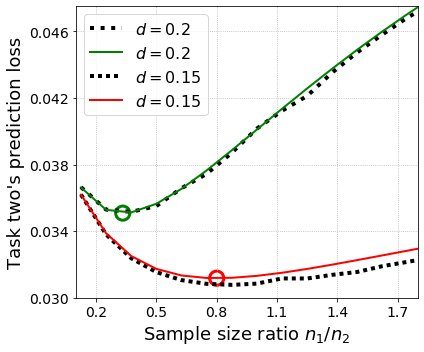

In [59]:
c1_list = [50 * i for i in range(1, 17)]
c2 = 400

te_mtl_list_002 = [0.03664508426381106, 0.03529525763371753, 0.035161990189978155, 0.035508234404475154, 0.03658095487231149, 0.0374418590525242, 0.03870622016541722, 0.040160041741410565, 0.04122852779419975, 0.042120684054500694, 0.043527202771201076, 0.04474004219195435, 0.04581506298641596, 0.04683599409008909, 0.04768867159901361, 0.048831365891372845]
estimate_list_002 = [0.036629011930984674, 0.03528340531328318, 0.035126886402250125, 0.03564466720288341, 0.03654242074507547, 0.03764687429862925, 0.03885391311628594, 0.0401002191804701, 0.04134716970715191, 0.04257139862614078, 0.043759112555804835, 0.04490258910444862, 0.04599797815797368, 0.04704389944188564, 0.04804053662348507, 0.0489890465100376]

te_mtl_list = [0.036200516238370825, 0.0338041386386532, 0.03237846769917451, 0.0315425075478014, 0.03106043739695919, 0.030839254903264286, 0.03077688374697106, 0.030850093273344235, 0.031162991896567068, 0.031159971596691607, 0.031378247890921224, 0.03155231475436127, 0.03190086046063125, 0.032159217751299096, 0.03241576898581232, 0.032665833207184344]
estimate_list = [0.03619402, 0.03387497, 0.03250933, 0.03173627, 0.03134094, 0.03119067,
 0.03120112, 0.03131732, 0.03150278, 0.03173284, 0.03199069, 0.03226471,
 0.03254688, 0.03283162, 0.03311506, 0.03339454]

#te_beta_t = te_target(X1, X2, beta_s, beta_t, 0)

plt.figure(figsize=(6,5))


plt.plot(np.array(c1_list) / c2, te_mtl_list_002, ls = ':', lw=4, c='k', label='$d = 0.2$')
plt.plot(np.array(c1_list) / c2, estimate_list_002, c='g', lw=2, label='$d = 0.2$')


plt.plot(np.array(c1_list) / c2, te_mtl_list, linestyle='--', dashes=(1, 1), lw=4, c='k', label='$d = 0.15$')
plt.plot(np.array(c1_list) / c2, estimate_list, c='r', lw=2, label='$d = 0.15$')


plt.scatter([0.3329], [0.035084582059294225], marker="o", s = 200, facecolors='none', edgecolors='g', lw=3)

plt.scatter([0.8004], [0.031179157688254737], marker="o", s = 200, facecolors='none', edgecolors='r', lw=3)

#plt.scatter(np.array(provable_pos[0]) / c2, 1.5* 100*(te_beta_t-np.array(provable_pos[1]) ), marker='+', s=300, lw=4, c='r', label='Predicted positive')
#plt.scatter(x_thy, 1.5 * y_thy, marker='_', s=300, lw=4, c='orange', label='Predicted negative')
#plt.scatter(np.array(unknown[0]) / c2, 1.5 * 100*(te_beta_t-np.array(unknown[1]) ), marker='o', s=20, lw=4, c='y')
#plt.plot(x_emp, 1.5 * y_emp, c='k', lw=3, ls=':', label='Empirical curve')

#plt.plot(np.arange(0,900,50), [te_beta_t] * 18, lw=3, c='k', ls='dotted', label='Single-task learning')

plt.xlabel(r'Sample size ratio $n_1 / n_2$', fontsize=18)
plt.ylabel('Task two\'s prediction loss', fontsize=18)

plt.xticks(np.arange(0.2, 2.0, 0.3), fontsize=14)
plt.yticks(np.arange(0.03, 0.05, 0.004), fontsize=14)
plt.xlim([0.1, 1.8])
plt.ylim([0.03, 0.0475])

plt.grid(ls = ':', lw=0.8)
plt.legend(fontsize=16, loc=2)

plt.tight_layout()
plt.savefig('sample_ratio_several_d.eps')